# "Understanding Windows"
> "DICOM images can contain a high amount of voxel values and windowing can be thought of as a means of manipulating these values in order to change the apperance of the image so particular structures are highlighted"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [medical_imaging, windowing, dicoms]
- image: images/windowing.PNG

## A Matter of Grayscale

DICOM images typically contain between 12–16 bits/pixel, which corresponds to approximately 4,096 to 65,536 shades of gray<sup>[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3043920/)</sup>.  Most medical displays and regular computer screens are often limited to 8 bits or 256 shades of gray.  There are high end medical displays that can display 1024 shades of gray (like the ones optimized for mammography).

However even with a computer screen that can display 256 shades of gray our eyes can typically only detect a **6%** change in grayscale<sup>[2](https://www.youtube.com/watch?v=KZld-5W99cI)</sup>

![shades of gray](images/gray.PNG)


That means we can typically only detect about $100/6$ = **17 shades of gray**

The [Hounsfield unit]<sup>[3](https://en.wikipedia.org/wiki/Hounsfield_scale)</sup> (**HU**) scale is a quantitative scale for describing radiodensity.  It applies a linear transformation where the radiodensity of distilled water at standard pressure and temperature (STP) is defined as **0 HU**, while the radiodensity of air at STP is defined as **-1000 HU**.

![HU range](images/hu.PNG)

(Image credit<sup>[4](https://web.archive.org/web/20070926231241/http://www.intl.elsevierhealth.com/e-books/pdf/940.pdf)</sup>) Most images will require viewing between **-1000 HU** (which is a reference for air) and **+1000 HU** (which typically references hard bone.

So a DICOM image can have a range of **2000 HU** (from -1000 HU to +1000 HU) and if we wanted to display this range on a computer screen which can only display 256 shades of grey: $2000/256 = 8$. Then each shade of gray would have a difference of 8 HU.

The human eye can only detect about 17 shades of gray so for humans to detect a difference in densities (within the image range of 2000 HU), each variation has to vary by: $256/17 * 8 = 120$ HU.  The difference between normal and pathologically altered tissue is usually a lot less than 120 HU and this is why applying `windows` is important.

## Windowing

**Windowing** can be thought of as a means of manipulating pixel values in order to change the apperance of an image so particular structures within the image are highlighted.

To futher explain how `windowing` works we use this [dataset](https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection), import the `fastai` dependancies and load a test image.

In [56]:
#hide
from fastai.vision.all import *
from fastai.medical.imaging import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)

source = 'D:/Datasets/rsna_pulmonary'
files = get_dicom_files(source)
patient6 = files[6].dcmread()

Viewing the `pixel_array`

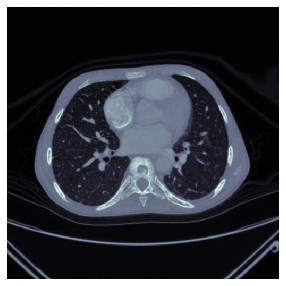

In [57]:
show_image(patient6.pixel_array, cmap=plt.cm.bone);

The difference when using `fastai` is that by default it will display the normalized image when the `show` function is used.

1 frame per file


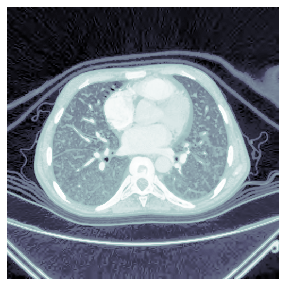

In [44]:
patient6.show();

Clearly there is alot more depth displayed in the image.  However this can be an issue when trying to localize areas that are normal to those that have been pathologically altered due to a condition. In most cases the difference in Hounsfeld units between normal and pathologically altered tissue can be very small.

![HU](images/tempsnip2.PNG)

The normalized image displays a wide range of tissue densities(ranging from -1000HU (air) to around +1000HU (bone)).  As mentioned above a regular computer screen can only display 256 shades of grey and our eye can only deduct about a 6% change in grayscale<sup>[2](https://www.youtube.com/watch?v=KZld-5W99cI)</sup>

The basis of applying `windows` is to focus down the 256 shades of grey into a narrow region of Hounsfled units that contain the relevant densities of tissues we may be interested in.

### `Fastai`'s in-built windows

The Fastai medical imaging library conveniently provides a number of window ranges that can be used by its `windowed` function.  The windows can be called by using `dicom_windows`

In [60]:
dicom_windows

namespace(abdomen_soft=(400, 50), brain=(80, 40), brain_bone=(2800, 600), brain_soft=(375, 40), liver=(150, 30), lungs=(1500, -600), mediastinum=(350, 50), spine_bone=(1800, 400), spine_soft=(250, 50), stroke=(8, 32), subdural=(254, 100))

### How do `windows` work?

A window has 2 values:

- `window level` or `center`, also known as brightness, `l`
- `window width` or `range`, also known as contrast, `w`

Window pixel values are calculated using the following formulas:

- `lowest_visible_value` = window_level - window_width / 2
- `highest_visible_value` = window_level + window_width / 2

Using the brain window as an example: it has a `window width` of 80 and a `window level` of 40.

- lowest_visible_value = **40 - (80/2) = 0**
- highest_visible_value = **40 + (80/2) = 80**

In this case the `lowest_visible_value` will be **0** and the `highest_visible_value` of **80**.  This means that every pixel value **greater than 80** will show up as **white** and any value **below 0** will show up as **black**. 

In [63]:
scaled = scaled_px(patient6)

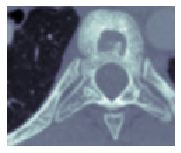

In [90]:
scale1 = sm_scaled[150:250,:]
show_image(scale1, cmap='bone')

In [76]:
df = pd.DataFrame(scale1)
df.style.set_properties(**{'font-size':'8pt'}).background_gradient('bone').format("{:.1f}")

In [94]:
wind2 = scale1.windowed(*dicom_windows.brain)

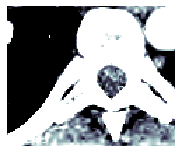

In [95]:
show_image(wind2, cmap=plt.cm.bone)

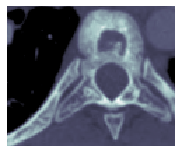

In [93]:
wind22 = scale1.windowed(*dicom_windows.spine_bone)
show_image(wind22, cmap=plt.cm.bone)

In [85]:
dfs = pd.DataFrame(wind2)
dfs.style.set_properties(**{'font-size':'6pt'}).background_gradient('bone').format("{:.1f}")

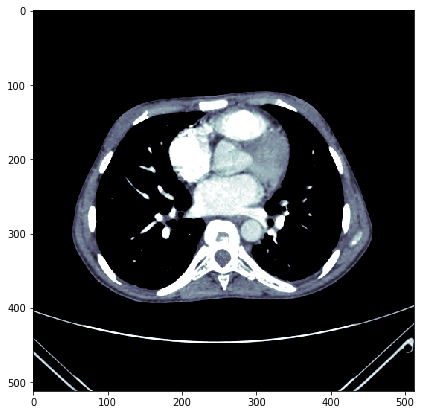

In [55]:
plt.imshow(patient6.windowed(*dicom_windows.mediastinum), cmap=plt.cm.bone);

## References

<sup>1</sup>[Increasing the Number of Gray Shades in Medical Display Systems—How Much is Enough?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3043920/)

<sup>2</sup>[Understanding CT windows, levels and densities](https://www.youtube.com/watch?v=KZld-5W99cI)

<sup>3</sup>[Hounsfield scale](https://en.wikipedia.org/wiki/Hounsfield_scale)

<sup>4</sup>[Image Credit](https://web.archive.org/web/20070926231241/http://www.intl.elsevierhealth.com/e-books/pdf/940.pdf)

{{ "This is the actual footnote" | fndetail: 15 }}

{{ 'This is the actual footnote; with a [link](www.github.com) as well! and a single quote &#39; too!'  | fndetail: 20 }}